<a href="https://colab.research.google.com/github/PSindhuLakshmiPriya/FMML_ASSIGNMENTS/blob/main/FMML_Course_Topic_8_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 4 - Probabilisitic Mixture Models

Lab by V Vijay Vignesh

vijay.vignesh@research.iiit.ac.in

In [1]:
!pip install pymc

In [2]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import animation as anim
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import sklearn, sklearn.cluster, sklearn.mixture
import pymc as pm

In [3]:
plt.style.use('ggplot')
np.random.seed(1243451432)
color_map = ['green', 'red', 'purple', 'blue', 'orange']

## Training Probabilistic Models

### Let's some data for Unsupervised Clustering

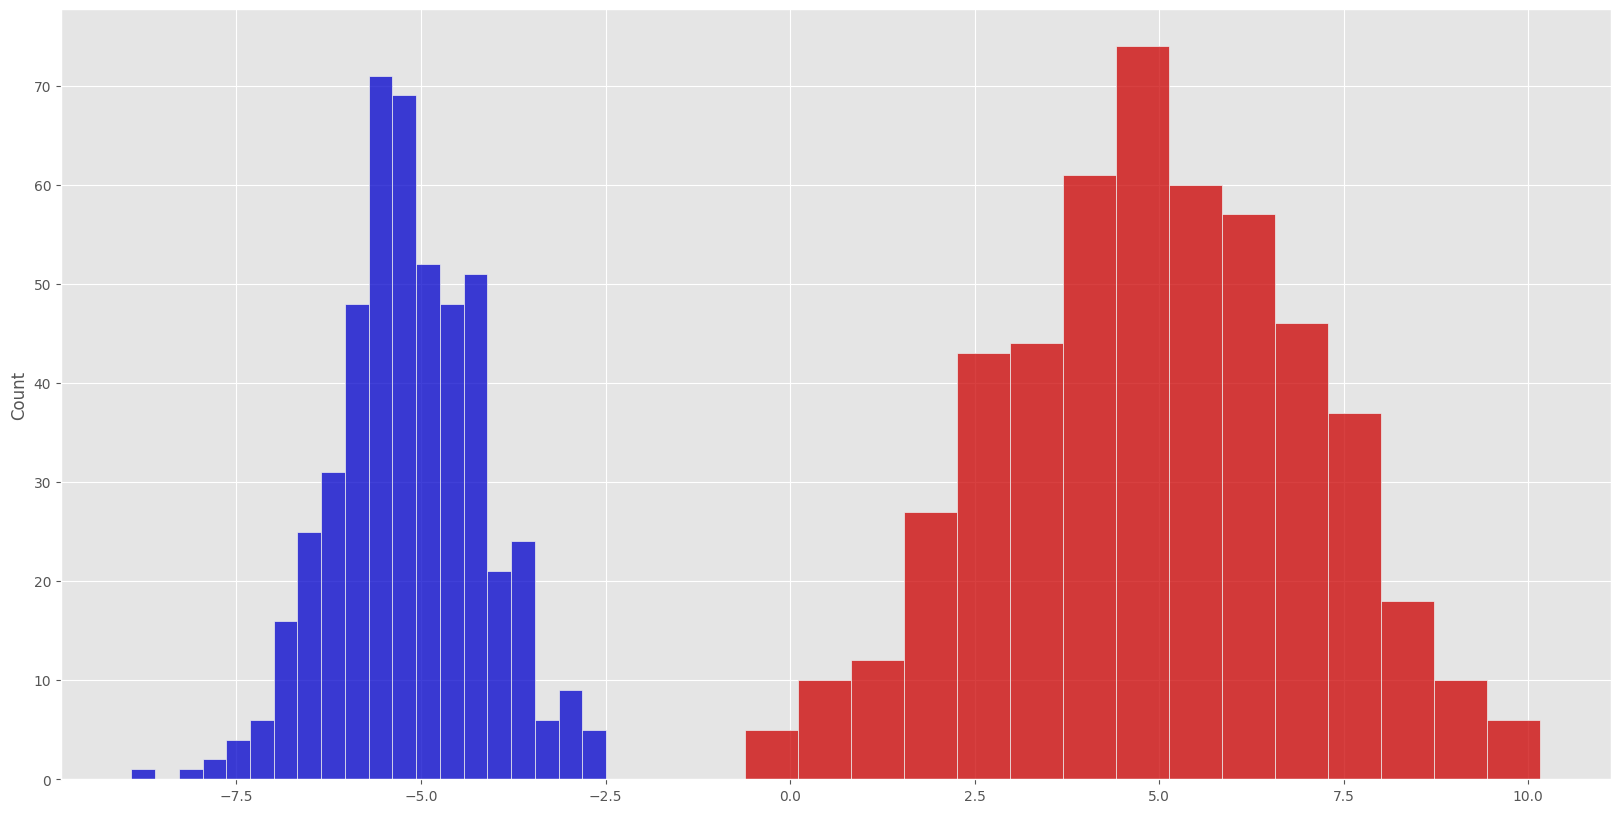

In [4]:
y = np.random.choice([0, 1], p=[0.5, 0.5], size=1000)
true_mu_1 = -5.0
true_mu_2 = 5.0
true_sigma_1 = 1.0
true_sigma_2 = 2.0
X = (y == 0) * np.random.normal(true_mu_1, true_sigma_1, size=len(y)) + (y == 1) * np.random.normal(true_mu_2, true_sigma_2, size=len(y))

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(X[y == 0], ax=ax, color='#0000CC')
sns.histplot(X[y == 1], ax=ax, color='#CC0000')
plt.show()

### Expectation Maximization for 2 Classes

[-2.6776427   6.29702435] [4.74036188 6.44260667]
[-2.7780132   3.60550629] [5.04994722 5.6209604 ]
[-2.66950533  2.837141  ] [5.1160104  5.50083961]
[-2.466747   2.4971075] [5.13650168 5.47235704]


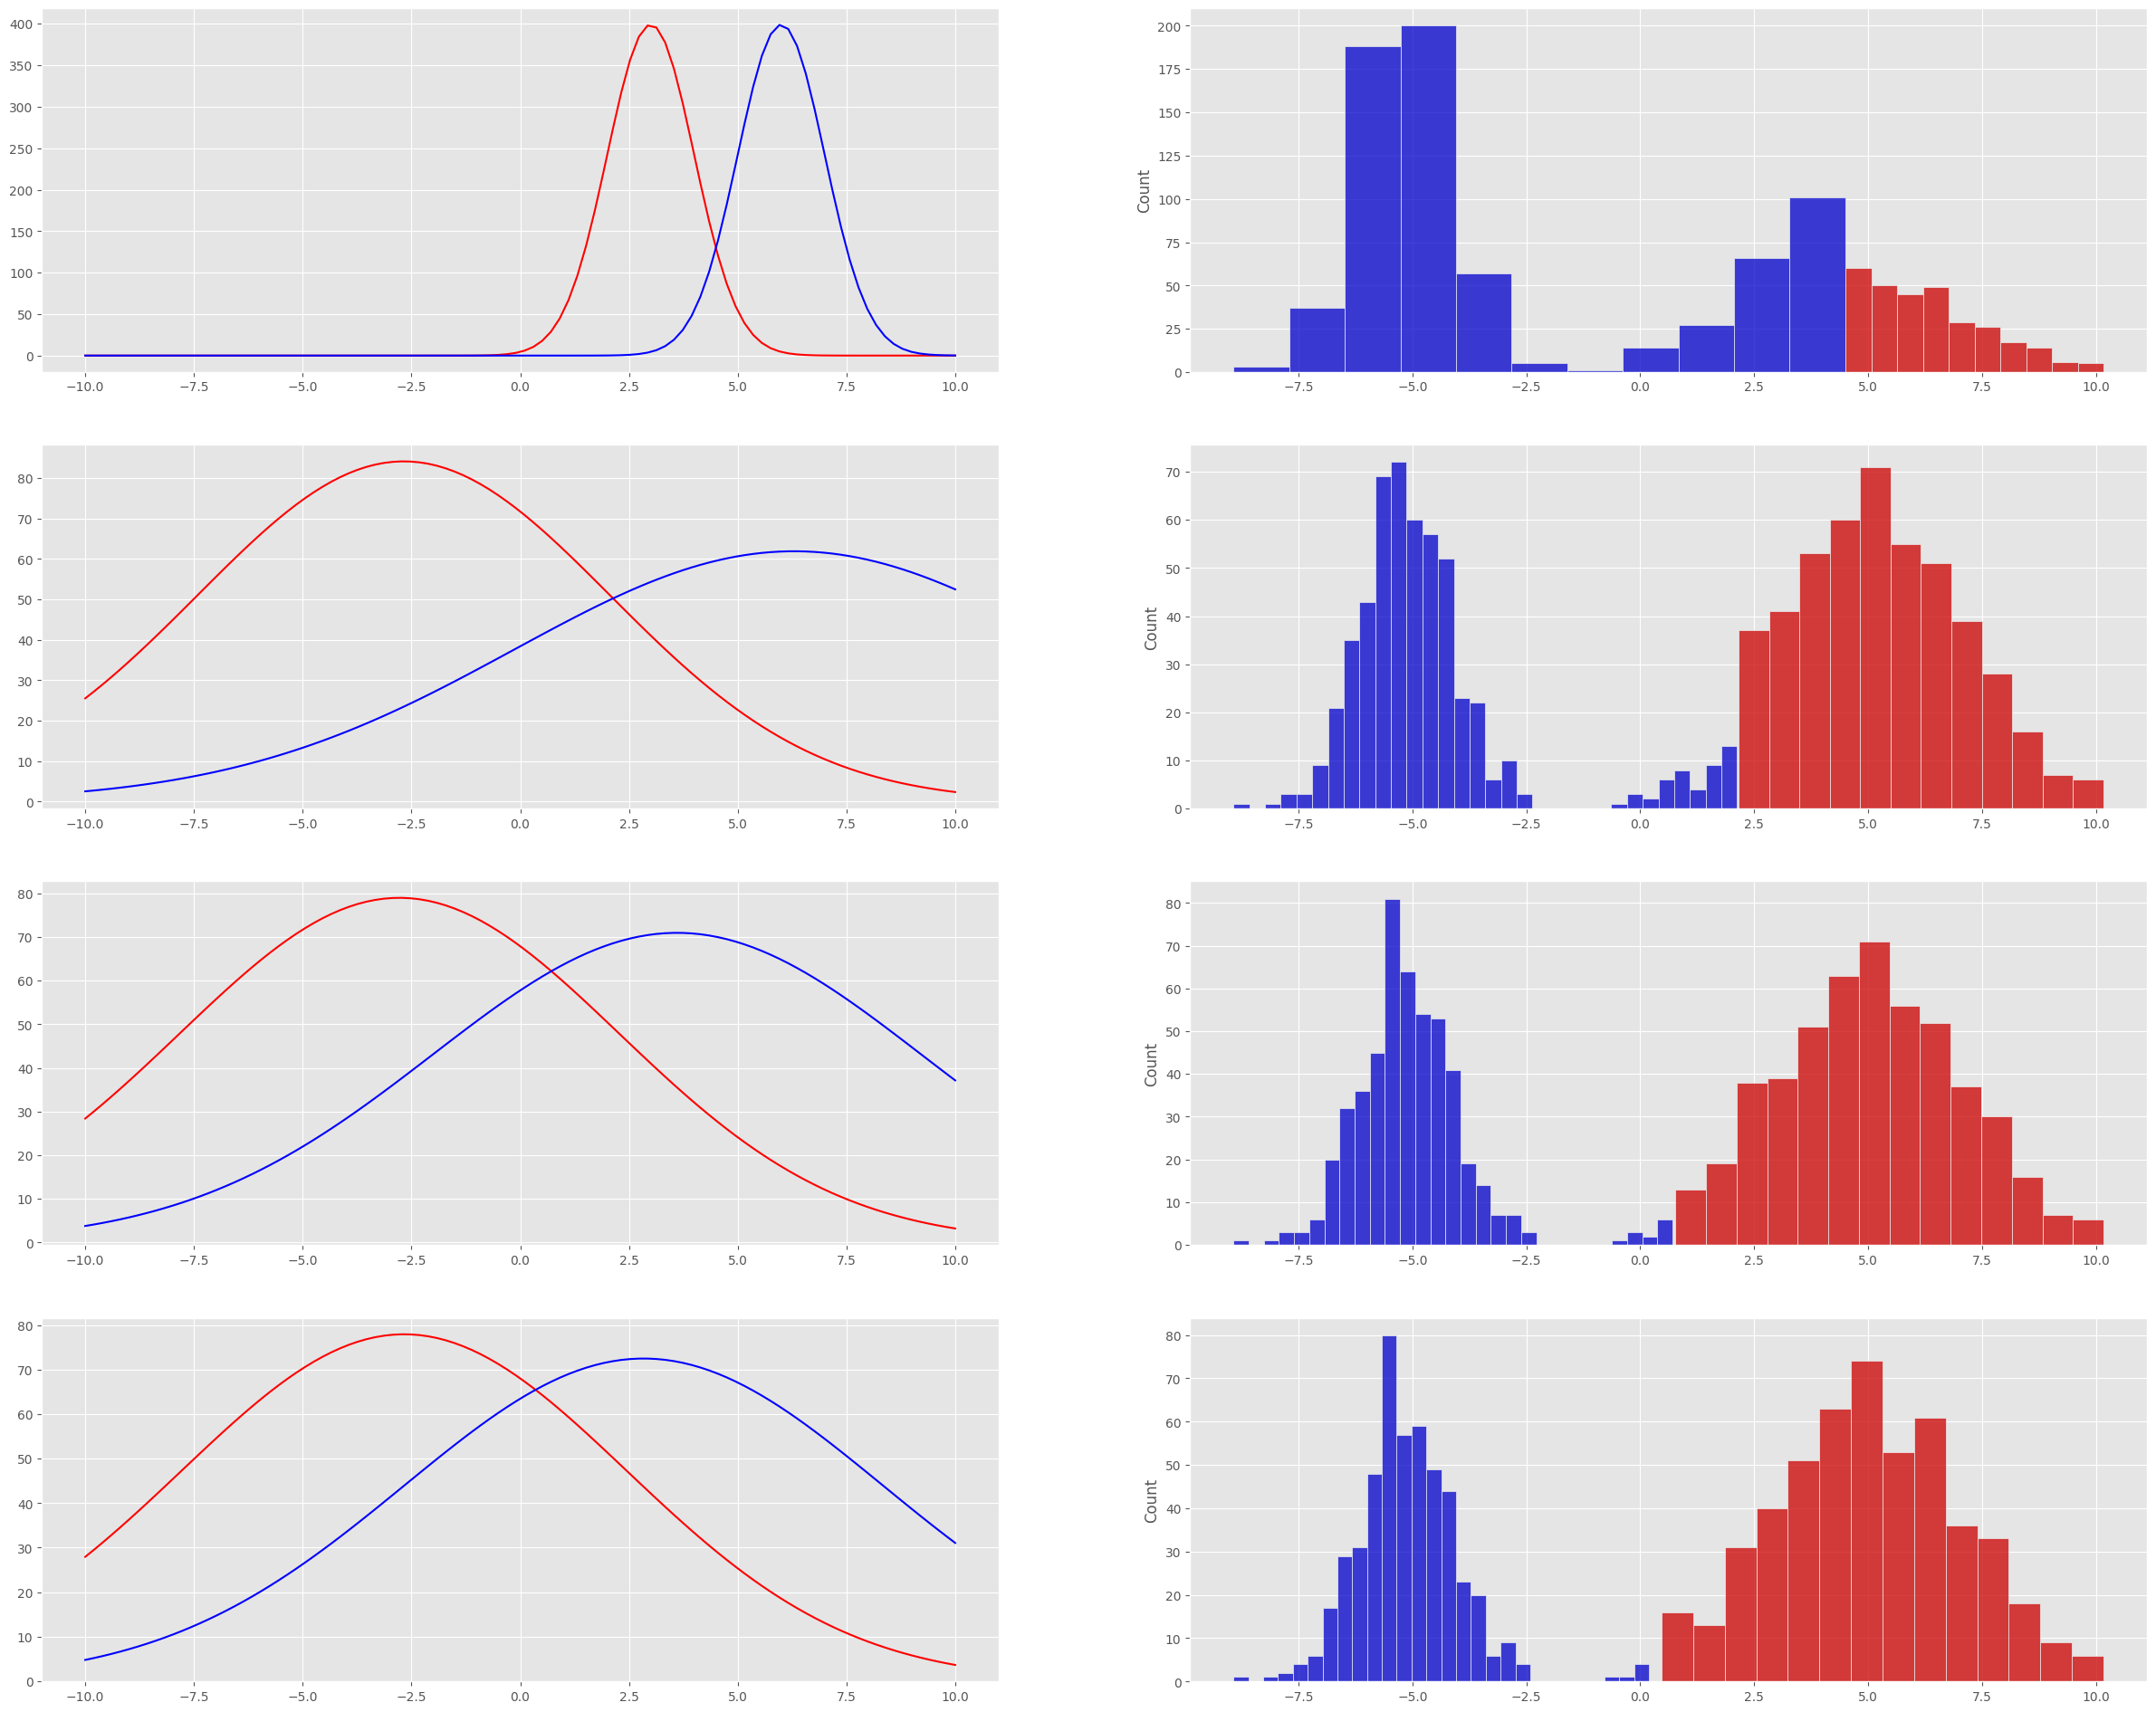

In [5]:
from matplotlib import rc
rc('animation', html='jshtml')

mu, sigma = np.array([3, 6]), np.array([1, 1])
z = np.random.random(size=len(X))
fig, ax = plt.subplots(4, 2, figsize=(15 * 2, 6 * 4))
ax = ax.reshape(-1)

def gaussian(mu, sigma, X):
    return np.exp(-0.5 * ((X - mu) / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)

def animate(i):
    global z, mu, sigma, ax
    ax[2 * i].cla()
    domain = np.linspace(-10, 10, 100)
    # Maximization Step
    p0 = gaussian(mu[0], sigma[0], X)
    p1 = gaussian(mu[1], sigma[1], X)
    z = p1 / (p0 + p1)
    ax[2 * i].plot(domain, 1000 * gaussian(mu[0], sigma[0], domain), color='r')
    ax[2 * i].plot(domain, 1000 * gaussian(mu[1], sigma[1], domain), color='b')
    # Plot stuff
    sns.histplot(X[z <= 0.5], ax=ax[2 * i + 1], color='#0000CC')
    sns.histplot(X[z > 0.5], ax=ax[2 * i + 1], color='#CC0000')
    # Expectation Step
    mu = np.array([np.sum((1 - z) * X) / np.sum(1 - z), np.sum(z * X) / np.sum(z)])
    sigma = np.array([np.sqrt(np.sum((1 - z) * X ** 2) / np.sum(1 - z)), np.sqrt(np.sum((z) * X ** 2) / np.sum(z))])
    print(mu, sigma)

for i in range(4):
    animate(i)

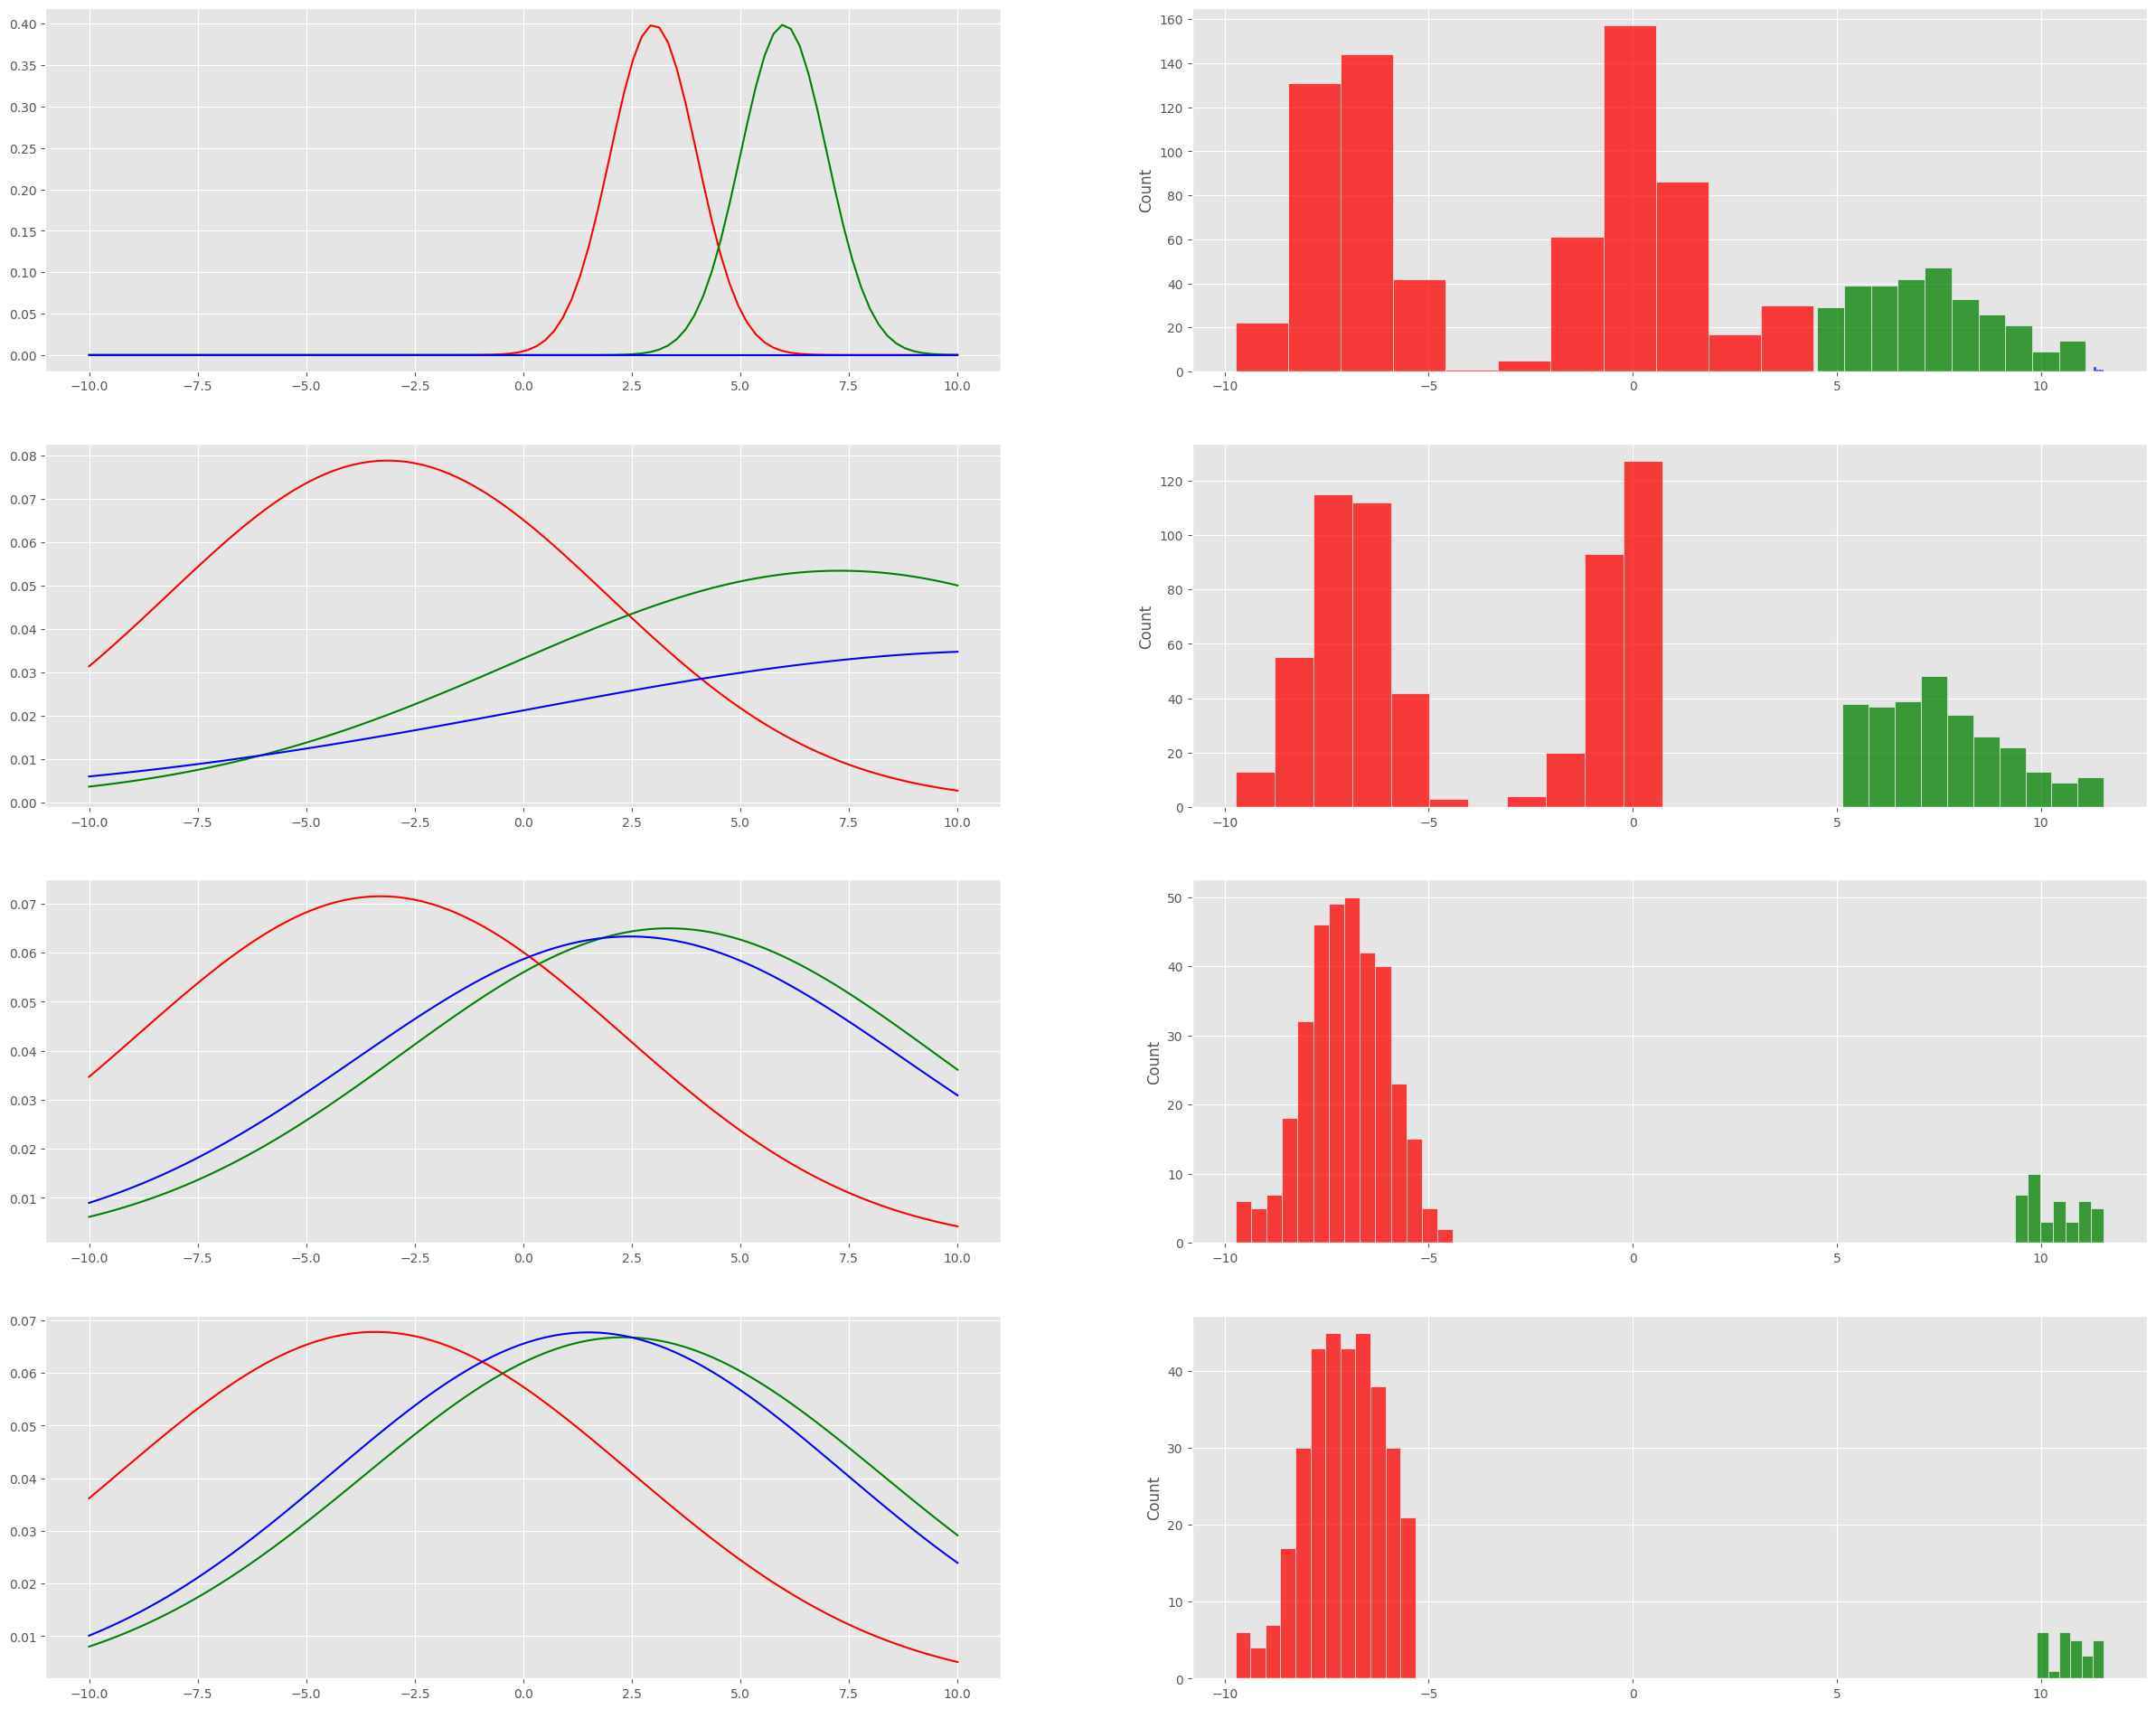

In [6]:
class GaussianMixture:

    def __init__(self, n_clusters, true_mu, true_sigma):
        self.n_clusters = n_clusters
        self.true_mu, self.true_sigma = true_mu, true_sigma
        self.y = np.random.choice(list(range(n_clusters)), p=[1/n_clusters for _ in range(n_clusters)], size=1000)
        self.X = np.sum(np.stack([(self.y == i) * np.random.normal(true_mu[i], true_sigma[i], size=len(y)) for i in range(n_clusters)], axis=0), axis=0)

        self.mu, self.sigma = np.array([3, 6, 15]), np.array([1, 1, 0.7])
        self.z = np.random.random((n_clusters, len(self.y)))
        self.z = self.z / np.reshape(np.sum(self.z, axis=0), (1, -1))
        self.colors = ['r', 'g', 'b', 'k', 'o', 'y'][:n_clusters]

    @staticmethod
    def gaussian(mu, sigma, X):
        return np.exp(-0.5 * ((X - mu) / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)

    def expectation(self):
        self.mu = np.array([np.sum(self.z[i] * self.X) / np.sum(self.z[i]) for i in range(self.n_clusters)])
        self.sigma = np.array([np.sqrt(np.sum(self.z[i] * self.X ** 2) / np.sum(self.z[i])) for i in range(self.n_clusters)])

    def maximization(self):
        self.z = np.stack([gaussian(self.mu[i], self.sigma[i], self.X) for i in range(self.n_clusters)], axis=0)
        self.z = self.z / np.reshape(np.sum(self.z, axis=0), (1, -1))

    def plot_full(self, iterations):
        z = np.random.random(size=len(self.X))
        fig, ax = plt.subplots(iterations, 2, figsize=(15 * 2, 6 * iterations))

        if len(ax.shape) == 1:
            ax = ax.reshape(1, ax.shape[0])

        for iter in range(iterations):
            ax[iter][0].cla()
            domain = np.linspace(-10, 10, 100)
            self.maximization()
            for i in range(self.n_clusters):
                ax[iter][0].plot(domain, gaussian(self.mu[i], self.sigma[i], domain), color=self.colors[i])
            for i in range(self.n_clusters):
                sns.histplot(self.X[self.z[i] > 0.5], ax=ax[iter][1], color=self.colors[i])
            self.expectation()

    def plot_truth():
        fig, ax = plt.subplots(figsize=(20, 10))
        for i in range(self.n_clusters):
            sns.histplot(X[y == i], ax=ax, color=self.colors[i])
        plt.show()


gmm = GaussianMixture(3, [-7.0, 0.0, 7.0], [1.0, 1.0, 2.0])
gmm.plot_full(4)

### The real math of Expectation Maximization (Optional)

Remember, that EM algorithm is a **coordinate descent** optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned, i.e. $t_i$  is the cluster index for object $x_i$.

The joint distribution can be written as follows: $\log p(T, X \mid \theta) =  \sum\limits_{i=1}^N \log p(t_i, x_i \mid \theta) = \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \log \left (\pi_c \, f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)\right)$,
where $f_{\!\mathcal{N}}(x \mid \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})
\right)$ is the probability density function (pdf) of the normal distribution $\mathcal{N}(x_i \mid \mu_c, \Sigma_c)$.

## Unsupervised Clustering - Gaussian Mixture Model

### Gaussian Mixtures Models in PyMC on 1-D data

First we start by generating some data as a sum of 3 Gaussians, so that we know how to optimally cluster it. The Gaussian Mixture Model will have no idea about the parameters of our model. Nevertheless, visually in our input, we can see the 3 modes in our data, and the data is distributed around these modes. These are what we will call clusters.

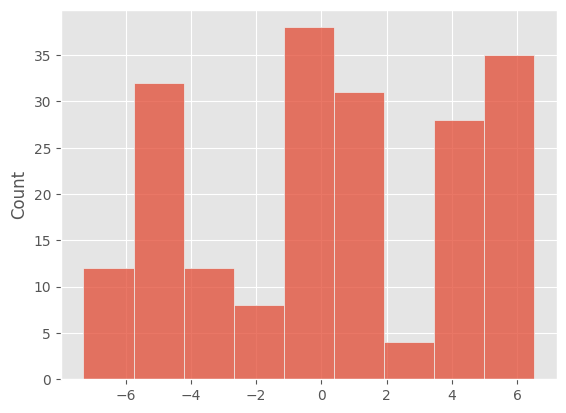

In [7]:
# simulate data from a known mixture distribution
k = 3
ndata = 200
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

sns.histplot(data);

In [8]:

# Model setup
with pm.Model() as model:
    p = pm.Dirichlet('p', a=np.ones(k))
    means = pm.Normal('means', mu=np.linspace(-spread, spread, k), sigma=15, shape=k, testval=centers)
    sd = pm.Uniform('sd', lower=0, upper=20)
    obs = pm.NormalMixture('obs', w=p, mu=means, sigma=sd, observed=data)

    # Sampling
    trace = pm.sample(1000, tune=5000, return_inferencedata=True)

<ipython-input-8-f701f3d77cb2>:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  means = pm.Normal('means', mu=np.linspace(-spread, spread, k), sigma=15, shape=k, testval=centers)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


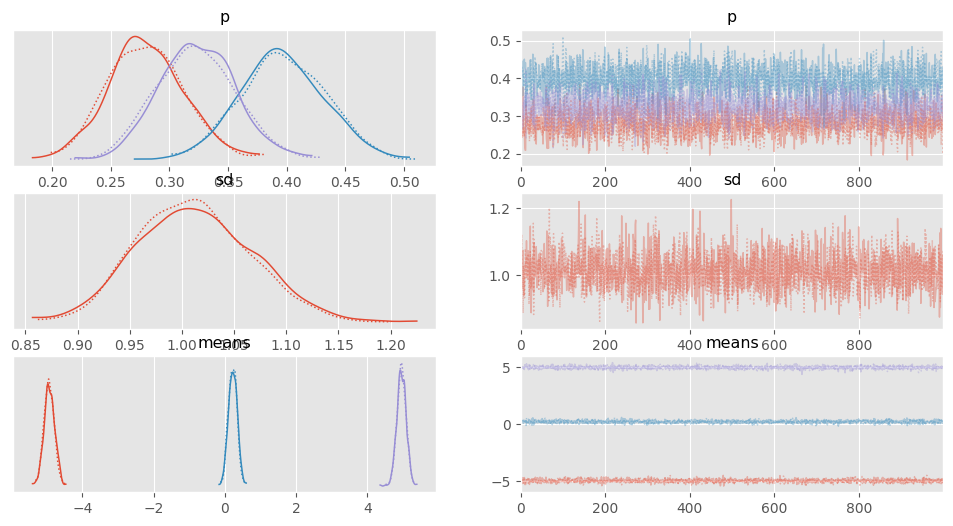

In [9]:
with model:
    pm.plot_trace(trace, var_names=["p", "sd", "means"])

### Recalling what KMeans gave us 2-D data

We have already sesen the use of KMeans clustering, here we will visualize KMeans as a special case of Probabilisitic Clustering.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


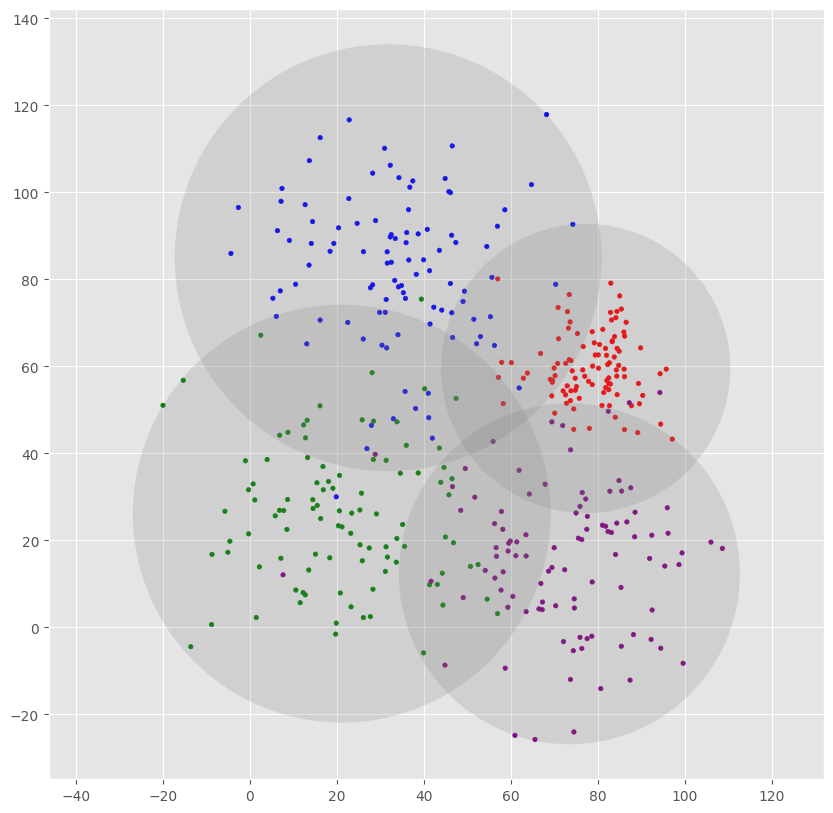

In [10]:
size, classes = 100, 4
plt.figure(figsize=(10, 10))
loc = np.array([[23, 25], [80, 61], [74, 13], [33, 82]])
var = np.array([[15, 18], [21, 8], [19, 15], [13, 17]])

X = np.vstack([np.stack([np.random.normal(loc=mean[0], scale=variance[1], size=size),
                         np.random.normal(loc=mean[1], scale=variance[1], size=size)],
                        axis=-1) for mean, variance in zip(loc, var)])
y = np.hstack([np.full(size, fill_value=i) for i in range(classes)])

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=list(map(lambda x: color_map[x], y)), s=10)
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [np.sqrt(np.sum((X[labels == i] - center) ** 2, axis=1).max()) for i, center in enumerate(centers)]
    for i, (c, r) in enumerate(zip(centers, radii)):
        ax.add_patch(plt.Circle(c, r, fc='gray', lw=3, alpha=0.2, zorder=1))

kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

### Applying GMMs to 2-D data

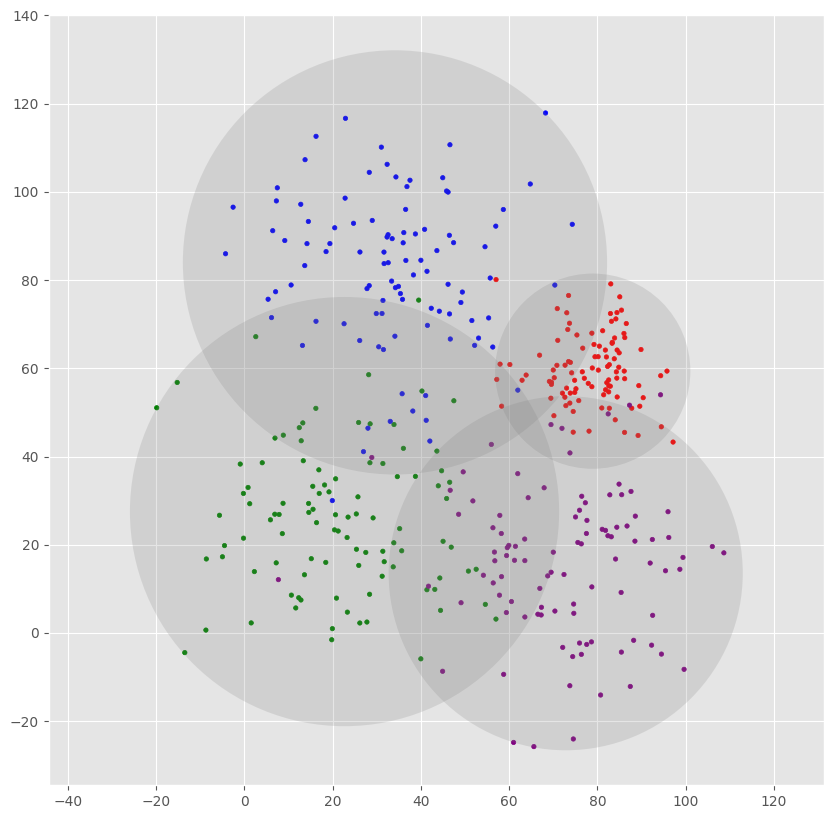

In [11]:
plt.figure(figsize=(10, 10))
def plot_gmm(gmm, X, n_clusters=4, rseed=0, ax=None):
    labels = gmm.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=list(map(lambda x: color_map[x], y)), s=10)
    # plot the representation of the gmm model
    centers = gmm.means_
    radii = [np.sqrt(np.sum((X[labels == i] - center) ** 2, axis=1).max()) for i, center in enumerate(centers)]
    for i, (c, r) in enumerate(zip(centers, radii)):
        ax.add_patch(plt.Circle(c, r, fc='gray', lw=3, alpha=0.2, zorder=1))

gmm = sklearn.mixture.GaussianMixture(n_components=4, random_state=0)
plot_gmm(gmm, X)

## Topic Modelling - Latent Dirichlet Allocation

### Visualizing a Dirichlet Distribution

In [12]:
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

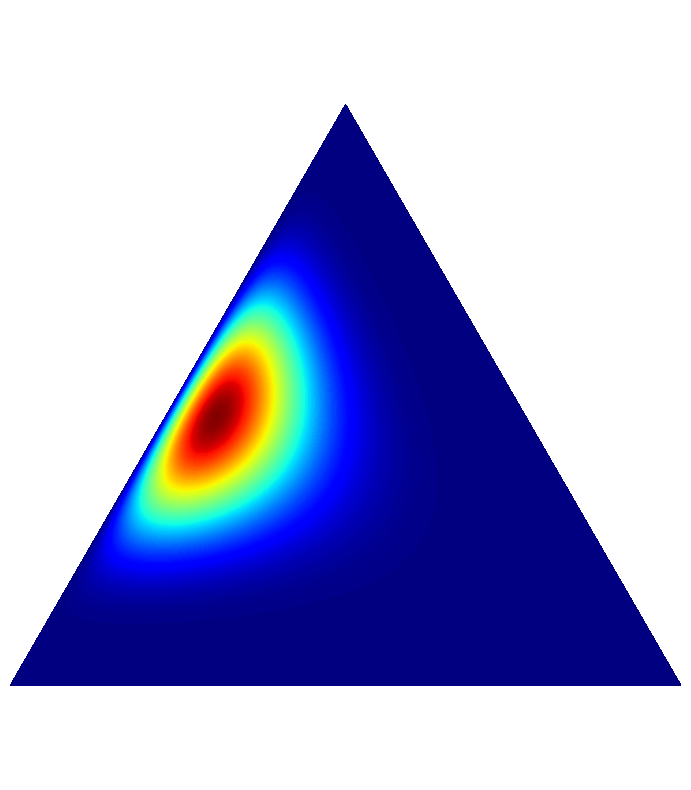

In [13]:
plt.figure(figsize=(10 * np.sqrt(3) / 2, 10))
x_weight = 7 #@param {type: "slider", min: 0.0, max: 10.0}
y_weight = 2 #@param {type: "slider", min: 0.0, max: 10.0}
z_weight = 7 #@param {type: "slider", min: 0.0, max: 10.0}
draw_pdf_contours(Dirichlet([x_weight, y_weight, z_weight]))

### Loading in the Data

In [14]:
import nltk
nltk.download("stopwords")
nltk.download("inaugural")
from nltk.corpus import inaugural
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.


In [15]:
data_dict = {'president': [], 'year': [], 'speech': []}
for fileid in inaugural.fileids():
    speech_string = ""
    for word in inaugural.words(fileid):
        word = word.lower()
        if word not in stops and word.isalpha():
            speech_string += word + ' '
    data_dict["speech"].append(speech_string)
    data_dict["year"].append(fileid[:4])
    data_dict["president"].append(fileid[5:-4])
df = pd.DataFrame(data_dict)
df

,president,year,speech
0,Washington,1789,fellow citizens senate house representatives a...
1,Washington,1793,fellow citizens called upon voice country exec...
2,Adams,1797,first perceived early times middle course amer...
3,Jefferson,1801,friends fellow citizens called upon undertake ...
4,Jefferson,1805,proceeding fellow citizens qualification const...
5,Madison,1809,unwilling depart examples revered authority av...
6,Madison,1813,add solemnity oath obligations imposed second ...
7,Monroe,1817,destitute feeling deeply affected strong proof...
8,Monroe,1821,fellow citizens shall attempt describe gratefu...
9,Adams,1825,compliance usage coeval existence federal cons...


### Preprocessing and Vector generation

In [16]:
from collections import defaultdict

vocab = defaultdict(int)
for idx, speech in enumerate(df["speech"]):
    for word in speech.split():
        vocab[word] += 1
vocab = np.sort(np.array(list(filter(lambda x: vocab[x] > 50, vocab.keys()))))
word_to_index = {word: idx for idx, word in enumerate(vocab)}

print("Constructed Vocabulary of", len(vocab), "words.")

Constructed Vocabulary of 203 words.


Number of words accounted for: 23087 (35.23549342205671%)


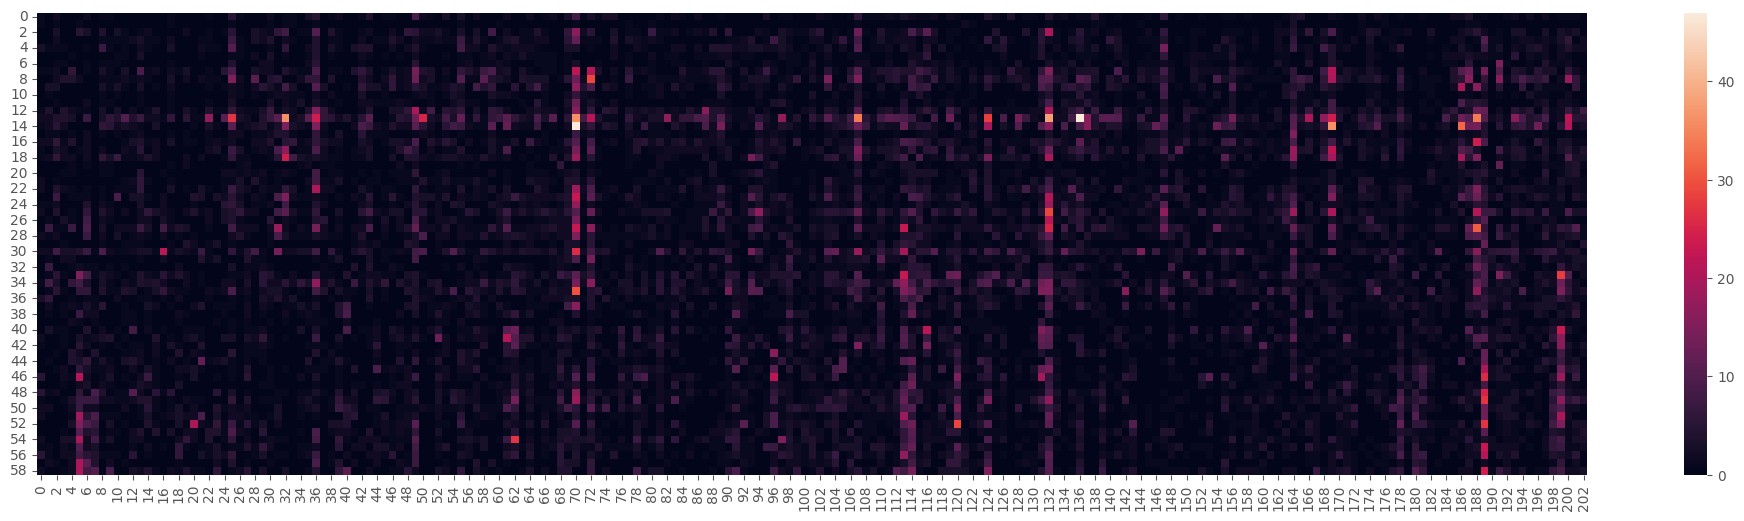

In [17]:
speech_vectors = np.zeros(shape=(len(df), len(vocab)))
for idx, speech in enumerate(df["speech"]):
    for word in speech.split():
        if word in word_to_index:
            speech_vectors[idx, word_to_index[word]] += 1

print(f"Number of words accounted for: {int(np.sum(speech_vectors))} ({100 * np.sum(speech_vectors) / np.sum(df['speech'].apply(lambda x: len(x.split())))}%)")

plt.figure(figsize=(25, 6))
sns.heatmap(speech_vectors)
plt.show()

### Using SKLearn to try out LDA

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=4, random_state=0)
lda.fit(speech_vectors)
res = lda.transform(speech_vectors)

In [19]:
for i in range(4):
    print(f"Topic {i+1}:", " ".join([vocab[word] for word in lda.components_[i].argsort()[:5]]))

Topic 1: revenue ought constitutional proper policy
Topic 2: help today business cannot seek
Topic 3: americans democracy help today know
Topic 4: revenue protection congress civil interests


In [20]:
df["topic"] = res.argmax(axis=1)
for i in range(4):
    print(f"Presidents on topic {i+1}:", " ".join(df["president"].loc[df["topic"] == i].unique()))
print()
df["topic"] = res.argmax(axis=1)
for i in range(4):
    print(f"Years on topic {i+1}:", " ".join(df["year"].loc[df["topic"] == i].unique()))

Presidents on topic 1: Kennedy Johnson Nixon Carter Reagan Bush Clinton Obama Trump Biden
Presidents on topic 2: Jefferson Harrison Lincoln
Presidents on topic 3: Washington Adams Jefferson Madison Monroe Jackson VanBuren Polk Taylor Pierce Buchanan Lincoln Grant Hayes Garfield Cleveland Harrison McKinley Taft Coolidge Hoover Roosevelt
Presidents on topic 4: Roosevelt Wilson Harding Truman Eisenhower

Years on topic 1: 1961 1965 1969 1973 1977 1981 1985 1989 1993 1997 2001 2005 2009 2013 2017 2021
Years on topic 2: 1801 1841 1865
Years on topic 3: 1789 1793 1797 1805 1809 1813 1817 1821 1825 1829 1833 1837 1845 1849 1853 1857 1861 1869 1873 1877 1881 1885 1889 1893 1897 1901 1909 1925 1929 1933
Years on topic 4: 1905 1913 1917 1921 1937 1941 1945 1949 1953 1957


### Implementating Latent Dirichlet Allocation (Optional)

**The specific code for LDA is not needed, and is available as a library function in SKLearn. Code sample for the same is provided in the following section**

In [21]:
class LatentDirichletAllocation:

    def __init__(self, data, topics=10):
        """
        Takes the data variable and outputs a model
        """
        self.data = data
        self.num_topics, self.num_vocab, self.num_docs = self.data.shape[1] + 1, self.data.shape[0], topics
        self.alpha, self.beta = np.ones(self.num_topics), np.ones(self.num_vocab)
        with pm.Model() as model:
            self.theta = pm.Dirichlet("thetas", a=self.alpha, shape=(self.docs, self.vocab))
            self.phi = pm.Dirichlet("phis", a=self.beta, shape=(K, V))
            self.z = pm.Categorical("zx", p=thetas, shape=(W, D))
            self.w = pm.Categorical("wx", p=t.reshape(phis[z], (D*W, V)), observed=data.reshape(D*W))
        self.model = pm.Model([self.theta, self.phi, self.z, self.w])
        self.mcmc = pm.MCMC(self.model)

    def fit(self, iterations=1000, burn_in=10):
        self.mcmc.sample(iterations, burn=burn_in)

    @property
    def topics(self):
        return self.phi.value

    @property
    def words(self):
        return self.W.value

    @staticmethod
    def kl_divergence(p, q):
        return np.sum(p*np.log10(p/q))

    @staticmethod
    def cosine_similarity(x, y):
        return np.dot(x,y) / np.sqrt(np.dot(x,x) * np.dot(y,y))

    def sorted_docs_sim(self):
        kldivs_docs = [(i, j, self.kl_divergence(self.theta[i].value,self.theta[j].value),
                        self.cosine_similarity(self.data[i], self.data[j]))
                       for i in range(len(self.theta)) for j in range(len(self.theta))
                       if i != j]
        return sorted(kldivs_docs, key=lambda x: x[3], reverse=True)

    def show_topic_words(self, idwords, n=10):
        for i, t in enumerate(self.phi.value):
            print("Topic %i : " % i, ", ".join(idwords[w_] for w_ in np.argsort(t[0])[-10:] if w_ < (self.vocab-1-1)))

    def plot_words_per_topic(self, ax=None):
        if ax is None:
            plt.clf()
            fig, ax = plt.subplots(1,1)
        words = self.Z.value
        topic_dist = dict()
        for k_i in words:
            for k in k_i:
                if k not in topic_dist:
                    topic_dist[k] = 0
                topic_dist[k] += 1
        ax.bar(topic_dist.keys(), topic_dist.values())
        ax.set_xlabel("Topics")
        ax.set_ylabel("Counts")
        ax.set_title("Document words per topics")
        plt.show()

    def plot_word_dist(self, ax=None):
        topics = self.phi.value
        if ax is None:
            plt.clf()
            fig, ax = plt.subplots((len(topics)+1)/2, 2, figsize=(10,10))
        for i, t in enumerate(topics):
            ax[i/2][i%2].bar(range(len(t[0])), t[0])
            ax[i/2][i%2].set_title("Topic %s" % i)
        plt.suptitle("Vocab word proportions per topic")
        fig.subplots_adjust(hspace=0.5, wspace=0.5)